<a href="https://colab.research.google.com/github/giovanirojascuela/2025_5TO01/blob/main/TALLER/EXPOSICION/Sandra_Vanessa_Mamani_Chambi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación del Consumo Energético en Edificios Usando Random Forest

**Importar las librerías necesarias**

In [37]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [24]:
# 2. Cargar el dataset manualmente desde Colab (sube tu CSV)
from google.colab import files
uploaded = files.upload()

# Leer archivo subido
df = pd.read_csv('Energy_Consumption_Prediction.csv')  # Asegúrate de que el nombre coincida


Saving Energy_Consumption_Prediction.csv to Energy_Consumption_Prediction.csv


In [25]:
# 3. Ver una muestra de los datos
df.head()

,Square_Footage,Appliance_Count,Insulation_Type,Average_Outdoor_Temperature,HVAC_Type,Building_Age,Occupancy_Rate,Lighting_Type,Peak_Hours_Usage,Season,Energy_Consumption_Class
0,0.374540,0.185133,0.261706,0.672703,0.571996,0.393636,0.648257,0.038799,0.720268,0.913578,High
1,0.950714,0.541901,0.246979,0.796681,0.805432,0.473436,0.172386,0.186773,0.687283,0.525360,Medium
2,0.731994,0.872946,0.906255,0.250468,0.760161,0.854547,0.872395,0.831246,0.095754,0.724910,Low
3,0.598658,0.732225,0.249546,0.624874,0.153900,0.340004,0.613116,0.766768,0.922572,0.436048,Medium
4,0.156019,0.806561,0.271950,0.571746,0.149249,0.869650,0.157204,0.350643,0.568472,0.630035,High


In [26]:
# 4. Analizar las variables más relevantes
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Square_Footage               1000 non-null   float64
 1   Appliance_Count              1000 non-null   float64
 2   Insulation_Type              1000 non-null   float64
 3   Average_Outdoor_Temperature  1000 non-null   float64
 4   HVAC_Type                    1000 non-null   float64
 5   Building_Age                 1000 non-null   float64
 6   Occupancy_Rate               1000 non-null   float64
 7   Lighting_Type                1000 non-null   float64
 8   Peak_Hours_Usage             1000 non-null   float64
 9   Season                       1000 non-null   float64
 10  Energy_Consumption_Class     1000 non-null   object 
dtypes: float64(10), object(1)
memory usage: 86.1+ KB


,Square_Footage,Appliance_Count,Insulation_Type,Average_Outdoor_Temperature,HVAC_Type,Building_Age,Occupancy_Rate,Lighting_Type,Peak_Hours_Usage,Season
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.490257,0.507017,0.502406,0.490375,0.494105,0.498464,0.493309,0.482371,0.486497,0.496795
std,0.292137,0.292190,0.290674,0.286489,0.286810,0.289195,0.289734,0.284914,0.282235,0.282153
min,0.004632,0.003218,0.000012,0.000653,0.000031,0.006184,0.001428,0.000241,0.000243,0.000053
25%,0.235973,0.241074,0.261351,0.241901,0.244974,0.249380,0.240222,0.235989,0.249384,0.264144
50%,0.496807,0.518734,0.500614,0.484279,0.494598,0.490403,0.484643,0.483991,0.478701,0.495187
75%,0.744320,0.760465,0.759104,0.737541,0.739993,0.739852,0.756464,0.714466,0.715905,0.736217
max,0.999718,0.999414,0.997821,0.999558,0.997749,0.999350,0.999461,0.998905,0.996013,0.999505


In [29]:
print(df.columns.tolist())

['Square_Footage', 'Appliance_Count', 'Insulation_Type', 'Average_Outdoor_Temperature', 'HVAC_Type', 'Building_Age', 'Occupancy_Rate', 'Lighting_Type', 'Peak_Hours_Usage', 'Season', 'Energy_Consumption_Class']


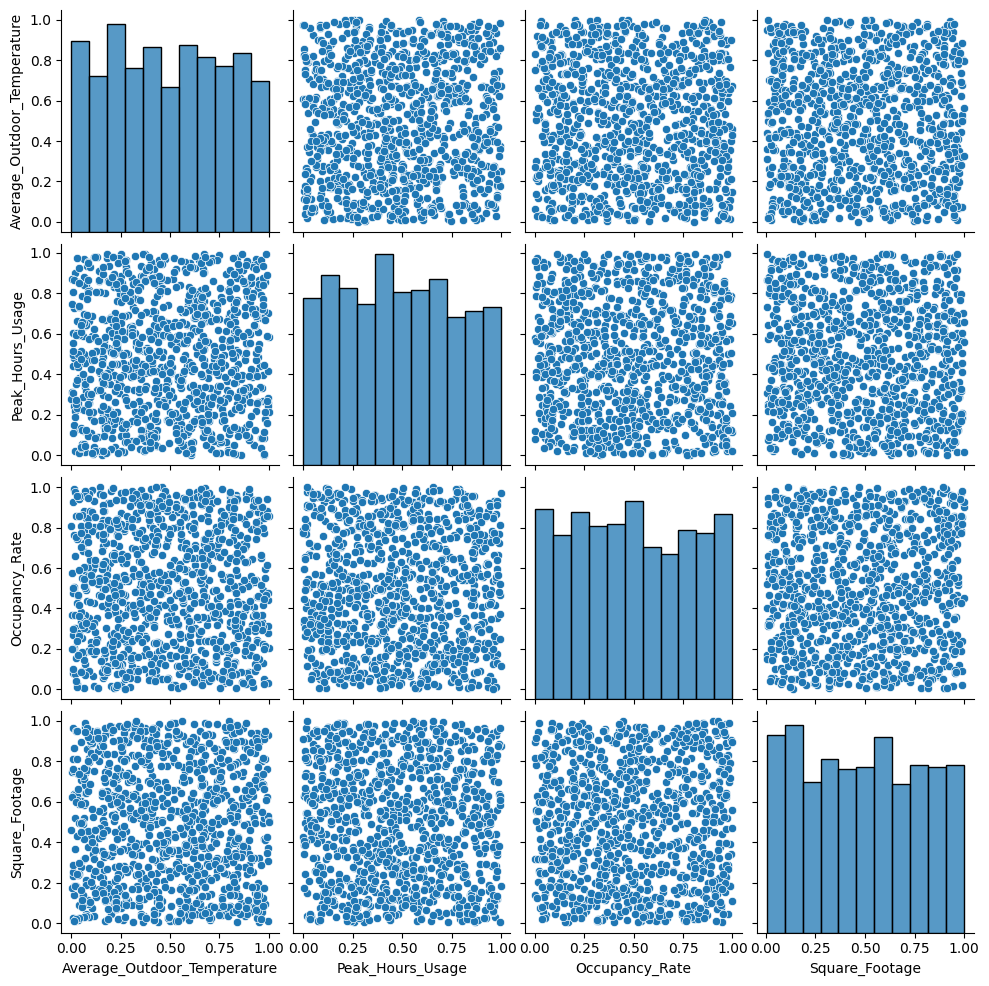

In [30]:
# 5. Visualizar relaciones clave
sns.pairplot(df[['Average_Outdoor_Temperature', 'Peak_Hours_Usage', 'Occupancy_Rate', 'Square_Footage']])
plt.show()

**Preparación de Datos**

In [35]:
df['Energy_Consumption_Class'].unique()


array(['High', 'Medium', 'Low'], dtype=object)

In [41]:
# Selección de la variable objetivo
target = 'Energy_Consumption_Class'

# Paso 1: Verifica qué columnas categóricas existen antes de aplicar get_dummies
columnas_categoricas = ['Insulation_Type', 'HVAC_Type', 'Lighting_Type', 'Season']
columnas_presentes = [col for col in columnas_categoricas if col in df.columns]

# Paso 2: Aplicar one-hot encoding solo a las columnas que realmente existen
if columnas_presentes:
    df = pd.get_dummies(df, columns=columnas_presentes, drop_first=True)

# Paso 3: Separar X e y
y = df[target]
X = df.drop(columns=[target])

print("Dimensión de X:", X.shape)
print("Dimensión de y:", y.shape)


Dimensión de X: (1000, 4002)
Dimensión de y: (1000,)


**Entrenamiento del Modelo**

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Separar en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de clasificación
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

**Evaluación del Modelo**

Accuracy: 0.36

Reporte de clasificación:
              precision    recall  f1-score   support

        High       0.37      0.38      0.37        64
         Low       0.71      0.13      0.22        76
      Medium       0.31      0.63      0.42        60

    accuracy                           0.36       200
   macro avg       0.47      0.38      0.34       200
weighted avg       0.48      0.36      0.33       200



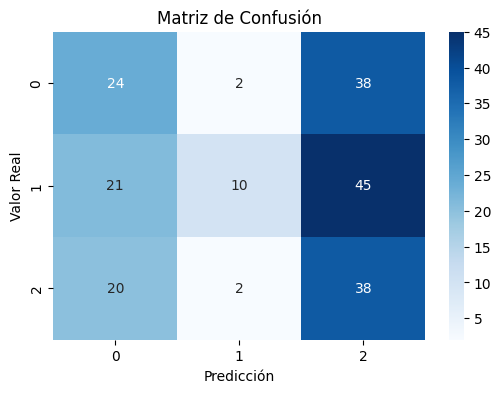

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción
y_pred = model.predict(X_test)

# Métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

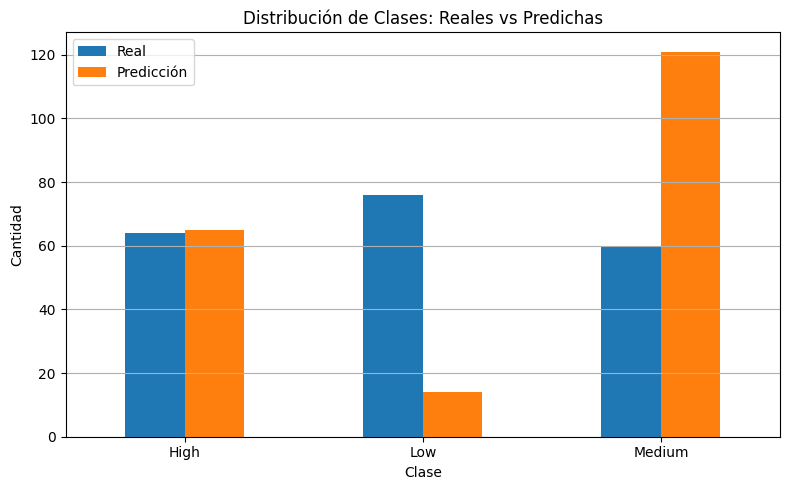

In [54]:
import pandas as pd

df_resultados = pd.DataFrame({'Real': y_test, 'Predicción': y_pred})

# Conteo por clase
conteo_real = df_resultados['Real'].value_counts().sort_index()
conteo_pred = df_resultados['Predicción'].value_counts().sort_index()

conteo_df = pd.DataFrame({'Real': conteo_real, 'Predicción': conteo_pred})

conteo_df.plot(kind='bar', figsize=(8,5))
plt.title("Distribución de Clases: Reales vs Predichas")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

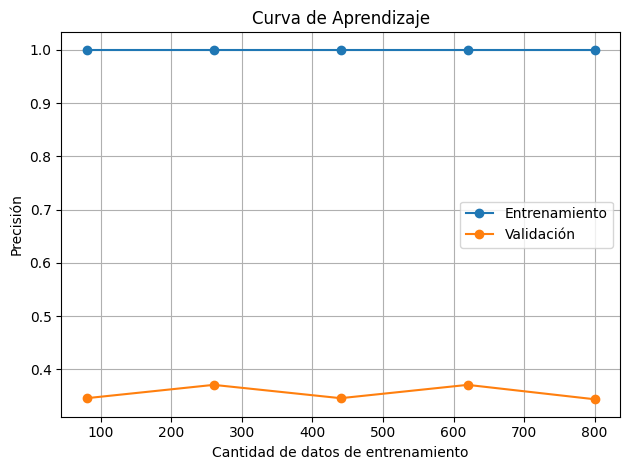

In [55]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, 'o-', label='Entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', label='Validación')
plt.title("Curva de Aprendizaje")
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Validación Cruzada**

In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Precisión promedio (validación cruzada): {scores.mean():.2f}")

Precisión promedio (validación cruzada): 0.34


In [48]:
scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
print(f"F1 Score promedio (validación cruzada): {scores.mean():.2f}")

F1 Score promedio (validación cruzada): 0.33


**Interpretación del Modelo**

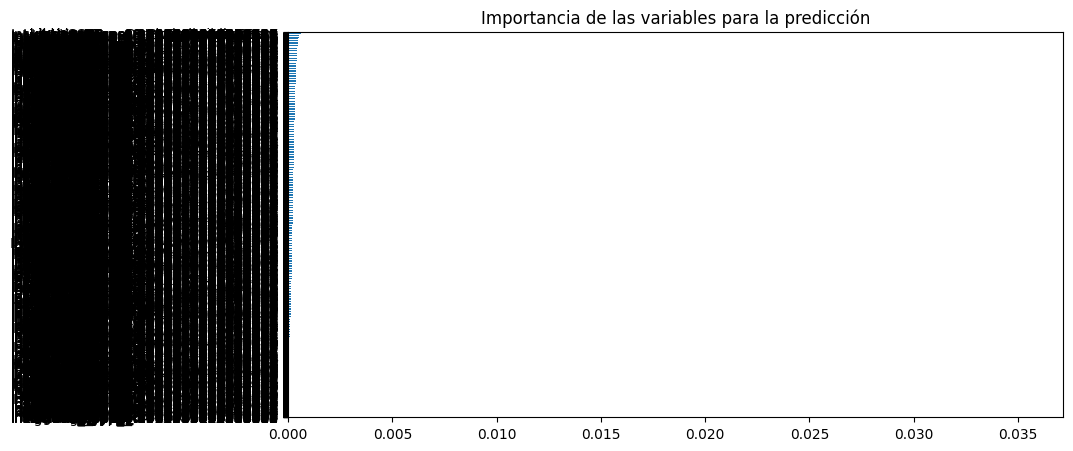

In [49]:
# Importancia de características
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(10,5))
plt.title("Importancia de las variables para la predicción")
plt.show()

**Aplicación del Modelo**

In [52]:
import joblib

# Guardar modelo
joblib.dump(model, 'modelo_consumo_rf.pkl')

# Luego puedes usarlo en una app Flask para predecir en tiempo real

['modelo_consumo_rf.pkl']